In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
keras = tf.keras

In [6]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


In [16]:
get_label_name = metadata.features['label'].int2str

In [7]:
IMG_SIZE = 160

def format_example(image, label): # IMG_SIZE로 변환된 image를 리턴한다
    image = tf.cast(image, tf.float32) # 이미지 안의 모든 값 -> float32로 바꾼다
    image = (image/127.5) - 1 # -1 ~ 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

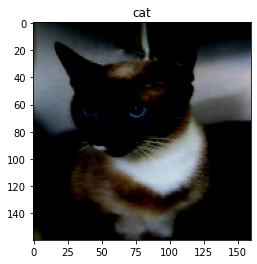

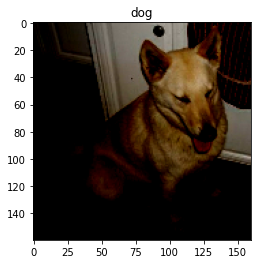

In [58]:
train = raw_train.map(format_example) # raw_train의 모든 값들에 format_example을 먹이는거
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

for image, label in test.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [59]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [48]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False, # classifier(분류하는 layer)를 포함할껀지 아닌지
                                                weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [49]:
base_model.trainable = False

In [50]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
"""
Kinda like Flatten but get global average values
5 x 5 x 1280
-> 1280 # w/average value of 5 x 5
"""

In [51]:
prediction_layer = keras.layers.Dense(1)

In [52]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [62]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
            loss = tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
model.summary()

In [65]:
initial_epochs = 3
validation_steps = 20

loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

 3/20 [===>..........................] - ETA: 24s - loss: 0.6908 - accuracy: 0.5104

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


15/20 [=====================>........] - ETA: 5s - loss: 0.7737 - accuracy: 0.4938

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


20/20 [==============================] - 22s 1s/step - loss: 0.7862 - accuracy: 0.4984


In [ ]:
history =  model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

acc = history.history['accuracy']
print(acc)

In [72]:
model.save('dogs_vs_cats.h5')
new_model = tf.keras.models.load_model("dogs_vs_cats.h5")
prediction = new_model.predict(test_batches)

26/73 [=========>....................] - ETA: 35s

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


73/73 [==============================] - 57s 735ms/step


In [73]:
print(prediction[0])

[-6.3885317]
